<a href="https://colab.research.google.com/github/Stecie06/Text_Classification/blob/main/Notebooks/GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving emails.csv to emails.csv


In [ ]:
import pandas as pd
import numpy as np
import nltk
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, InputLayer, GRU, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from gensim.models import Word2Vec
from datetime import datetime

# Download required NLTK data
nltk.download("punkt")
nltk.download("punkt_tab")
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# ============== EXPERIMENT LOGGING ==============
experiment_log = []

def log_experiment(model_type, config, train_acc, val_acc, test_acc, train_time):
    """Systematically log each experiment"""
    experiment_log.append({
        'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'model_type': model_type,
        'config': str(config),
        'train_accuracy': train_acc,
        'validation_accuracy': val_acc,
        'test_accuracy': test_acc,
        'training_time_seconds': train_time
    })

def save_experiment_log():
    """Save all experiments to CSV"""
    df_log = pd.DataFrame(experiment_log)
    df_log.to_csv('experiment_log.csv', index=False)
    print("\n✓ Experiment log saved to 'experiment_log.csv'")
    return df_log

In [ ]:
# ============== DATA LOADING & PREPROCESSING ==============
# Load data
df = pd.read_csv("emails.csv")

# Preprocessing function
stop_words = set(nltk.corpus.stopwords.words('english'))

def preprocess(text):
    tokens = nltk.word_tokenize(text.lower())
    tokens = [t for t in tokens if t not in string.punctuation]
    tokens = [t for t in tokens if t not in stop_words]
    return tokens

# Apply preprocessing
df['processed_text'] = df['text'].apply(lambda x: ' '.join(preprocess(x)))
df['tokens'] = df['text'].apply(preprocess)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    df['processed_text'], df['spam'], test_size=0.2, random_state=42
)

# Get tokenized versions for Word2Vec
X_train_tokens = df.loc[X_train.index, 'tokens'].tolist()
X_test_tokens = df.loc[X_test.index, 'tokens'].tolist()

In [ ]:
############### TF-IDF MODEL #######################
print("\n" + "="*60)
print("=== TF-IDF MODEL ===")
print("="*60)

# Hyperparameter tuning for TF-IDF
tfidf_configs = [
    {'max_features': 3000, 'ngram_range': (1, 1), 'min_df': 2},
    {'max_features': 5000, 'ngram_range': (1, 2), 'min_df': 2},
    {'max_features': 7000, 'ngram_range': (1, 2), 'min_df': 1},
]

best_tfidf_acc = 0
best_tfidf_config = None

for idx, config in enumerate(tfidf_configs, 1):
    print(f"\n--- TF-IDF Experiment {idx}/{len(tfidf_configs)} ---")
    print(f"Config: {config}")

    import time
    start_time = time.time()

    vectorizer = TfidfVectorizer(**config)
    X_train_tfidf = vectorizer.fit_transform(X_train).toarray()
    X_test_tfidf = vectorizer.transform(X_test).toarray()

    # Neural network hyperparameters
    model_tfidf = Sequential([
        InputLayer(input_shape=(X_train_tfidf.shape[1],)),
        Dense(256, activation="relu"),
        Dropout(0.3),
        Dense(128, activation="relu"),
        Dropout(0.3),
        Dense(64, activation="relu"),
        Dense(1, activation="sigmoid")
    ])

    model_tfidf.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    history_tfidf = model_tfidf.fit(
        X_train_tfidf, y_train,
        validation_split=0.1,
        epochs=10,
        batch_size=32,
        callbacks=[early_stop],
        verbose=0
    )

    train_time = time.time() - start_time

    # Evaluate
    train_loss, train_acc = model_tfidf.evaluate(X_train_tfidf, y_train, verbose=0)
    test_loss, test_acc = model_tfidf.evaluate(X_test_tfidf, y_test, verbose=0)
    val_acc = max(history_tfidf.history['val_accuracy'])

    # Log experiment
    log_experiment('TF-IDF', config, train_acc, val_acc, test_acc, train_time)

    print(f"Train Accuracy: {train_acc:.4f}")
    print(f"Val Accuracy: {val_acc:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Training Time: {train_time:.2f}s")

    if test_acc > best_tfidf_acc:
        best_tfidf_acc = test_acc
        best_tfidf_config = config
        print("★ NEW BEST MODEL!")

print(f"\n{'='*60}")
print(f"BEST TF-IDF CONFIG: {best_tfidf_config}")
print(f"BEST TF-IDF ACCURACY: {best_tfidf_acc:.4f}")
print(f"{'='*60}")


=== TF-IDF MODEL ===

--- TF-IDF Experiment 1/3 ---
Config: {'max_features': 3000, 'ngram_range': (1, 1), 'min_df': 2}


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Train Accuracy: 0.9989
Val Accuracy: 0.9935
Test Accuracy: 0.9913
Training Time: 14.57s
★ NEW BEST MODEL!

--- TF-IDF Experiment 2/3 ---
Config: {'max_features': 5000, 'ngram_range': (1, 2), 'min_df': 2}
Train Accuracy: 0.9989
Val Accuracy: 0.9935
Test Accuracy: 0.9939
Training Time: 16.88s
★ NEW BEST MODEL!

--- TF-IDF Experiment 3/3 ---
Config: {'max_features': 7000, 'ngram_range': (1, 2), 'min_df': 1}
Train Accuracy: 0.9996
Val Accuracy: 0.9978
Test Accuracy: 0.9930
Training Time: 37.51s

BEST TF-IDF CONFIG: {'max_features': 5000, 'ngram_range': (1, 2), 'min_df': 2}
BEST TF-IDF ACCURACY: 0.9939


In [ ]:
############### WORD2VEC SKIP-GRAM #######################
print("\n" + "="*60)
print("=== WORD2VEC SKIP-GRAM MODEL ===")
print("="*60)

# Hyperparameter tuning for Skip-gram
sg_configs = [
    {'vector_size': 100, 'window': 5, 'min_count': 2, 'epochs': 5, 'workers': 4},
    {'vector_size': 150, 'window': 5, 'min_count': 2, 'epochs': 5, 'workers': 4},
    {'vector_size': 100, 'window': 7, 'min_count': 1, 'epochs': 5, 'workers': 4},
]

MAX_LEN = 50
best_sg_acc = 0
best_sg_config = None

def embed_sentence(tokens, model, max_len, emb_size):
    vecs = []
    for word in tokens[:max_len]:
        if word in model.wv:
            vecs.append(model.wv[word])
        else:
            vecs.append(np.zeros(emb_size))
    while len(vecs) < max_len:
        vecs.append(np.zeros(emb_size))
    return np.array(vecs)

for idx, config in enumerate(sg_configs, 1):
    print(f"\n--- Skip-gram Experiment {idx}/{len(sg_configs)} ---")
    print(f"Config: {config}")

    start_time = time.time()

    w2v_sg = Word2Vec(
        sentences=X_train_tokens,
        sg=1,  # Skip-gram
        **config
    )

    EMB_SIZE = config['vector_size']

    X_train_sg = np.array([embed_sentence(tokens, w2v_sg, MAX_LEN, EMB_SIZE)
                           for tokens in X_train_tokens])
    X_test_sg = np.array([embed_sentence(tokens, w2v_sg, MAX_LEN, EMB_SIZE)
                          for tokens in X_test_tokens])

    # Neural network hyperparameters
    model_sg = Sequential([
        GRU(64, input_shape=(MAX_LEN, EMB_SIZE)),
        Dense(32, activation="relu"),
        Dense(1, activation="sigmoid")
    ])

    model_sg.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    history_sg = model_sg.fit(
        X_train_sg, y_train,
        validation_split=0.1,
        epochs=10,
        batch_size=32,
        callbacks=[early_stop],
        verbose=0
    )

    train_time = time.time() - start_time

    # Evaluate
    train_loss, train_acc = model_sg.evaluate(X_train_sg, y_train, verbose=0)
    test_loss, test_acc = model_sg.evaluate(X_test_sg, y_test, verbose=0)
    val_acc = max(history_sg.history['val_accuracy'])

    # Log experiment
    log_experiment('Skip-gram', config, train_acc, val_acc, test_acc, train_time)

    print(f"Train Accuracy: {train_acc:.4f}")
    print(f"Val Accuracy: {val_acc:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Training Time: {train_time:.2f}s")

    if test_acc > best_sg_acc:
        best_sg_acc = test_acc
        best_sg_config = config
        print("★ NEW BEST MODEL!")

print(f"\n{'='*60}")
print(f"BEST SKIP-GRAM CONFIG: {best_sg_config}")
print(f"BEST SKIP-GRAM ACCURACY: {best_sg_acc:.4f}")
print(f"{'='*60}")


=== WORD2VEC SKIP-GRAM MODEL ===

--- Skip-gram Experiment 1/3 ---
Config: {'vector_size': 100, 'window': 5, 'min_count': 2, 'epochs': 5, 'workers': 4}


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Train Accuracy: 0.9873
Val Accuracy: 0.9826
Test Accuracy: 0.9764
Training Time: 65.87s
★ NEW BEST MODEL!

--- Skip-gram Experiment 2/3 ---
Config: {'vector_size': 150, 'window': 5, 'min_count': 2, 'epochs': 5, 'workers': 4}
Train Accuracy: 0.9928
Val Accuracy: 0.9891
Test Accuracy: 0.9799
Training Time: 79.50s
★ NEW BEST MODEL!

--- Skip-gram Experiment 3/3 ---
Config: {'vector_size': 100, 'window': 7, 'min_count': 1, 'epochs': 5, 'workers': 4}
Train Accuracy: 0.9904
Val Accuracy: 0.9847
Test Accuracy: 0.9747
Training Time: 79.40s

BEST SKIP-GRAM CONFIG: {'vector_size': 150, 'window': 5, 'min_count': 2, 'epochs': 5, 'workers': 4}
BEST SKIP-GRAM ACCURACY: 0.9799


In [ ]:
############### WORD2VEC CBOW #######################
print("\n" + "="*60)
print("=== WORD2VEC CBOW MODEL ===")
print("="*60)

# Hyperparameter tuning for CBOW
cbow_configs = [
    {'vector_size': 100, 'window': 5, 'min_count': 2, 'epochs': 5, 'workers': 4},
    {'vector_size': 150, 'window': 5, 'min_count': 2, 'epochs': 5, 'workers': 4},
    {'vector_size': 100, 'window': 7, 'min_count': 1, 'epochs': 5, 'workers': 4},
]

best_cbow_acc = 0
best_cbow_config = None

for idx, config in enumerate(cbow_configs, 1):
    print(f"\n--- CBOW Experiment {idx}/{len(cbow_configs)} ---")
    print(f"Config: {config}")

    start_time = time.time()

    w2v_cbow = Word2Vec(
        sentences=X_train_tokens,
        sg=0,  # CBOW
        **config
    )

    EMB_SIZE = config['vector_size']

    X_train_cbow = np.array([embed_sentence(tokens, w2v_cbow, MAX_LEN, EMB_SIZE)
                             for tokens in X_train_tokens])
    X_test_cbow = np.array([embed_sentence(tokens, w2v_cbow, MAX_LEN, EMB_SIZE)
                            for tokens in X_test_tokens])

    # Neural network hyperparameters
    model_cbow = Sequential([
        GRU(64, input_shape=(MAX_LEN, EMB_SIZE)),
        Dense(32, activation="relu"),
        Dense(1, activation="sigmoid")
    ])

    model_cbow.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    history_cbow = model_cbow.fit(
        X_train_cbow, y_train,
        validation_split=0.1,
        epochs=10,
        batch_size=32,
        callbacks=[early_stop],
        verbose=0
    )

    train_time = time.time() - start_time

    # Evaluate
    train_loss, train_acc = model_cbow.evaluate(X_train_cbow, y_train, verbose=0)
    test_loss, test_acc = model_cbow.evaluate(X_test_cbow, y_test, verbose=0)
    val_acc = max(history_cbow.history['val_accuracy'])

    # Log experiment
    log_experiment('CBOW', config, train_acc, val_acc, test_acc, train_time)

    print(f"Train Accuracy: {train_acc:.4f}")
    print(f"Val Accuracy: {val_acc:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Training Time: {train_time:.2f}s")

    if test_acc > best_cbow_acc:
        best_cbow_acc = test_acc
        best_cbow_config = config
        print("★ NEW BEST MODEL!")

print(f"\n{'='*60}")
print(f"BEST CBOW CONFIG: {best_cbow_config}")
print(f"BEST CBOW ACCURACY: {best_cbow_acc:.4f}")
print(f"{'='*60}")


=== WORD2VEC CBOW MODEL ===

--- CBOW Experiment 1/3 ---
Config: {'vector_size': 100, 'window': 5, 'min_count': 2, 'epochs': 5, 'workers': 4}
Train Accuracy: 0.9911
Val Accuracy: 0.9869
Test Accuracy: 0.9799
Training Time: 60.87s
★ NEW BEST MODEL!

--- CBOW Experiment 2/3 ---
Config: {'vector_size': 150, 'window': 5, 'min_count': 2, 'epochs': 5, 'workers': 4}
Train Accuracy: 0.9889
Val Accuracy: 0.9869
Test Accuracy: 0.9782
Training Time: 55.52s

--- CBOW Experiment 3/3 ---
Config: {'vector_size': 100, 'window': 7, 'min_count': 1, 'epochs': 5, 'workers': 4}
Train Accuracy: 0.9926
Val Accuracy: 0.9935
Test Accuracy: 0.9843
Training Time: 54.23s
★ NEW BEST MODEL!

BEST CBOW CONFIG: {'vector_size': 100, 'window': 7, 'min_count': 1, 'epochs': 5, 'workers': 4}
BEST CBOW ACCURACY: 0.9843


In [ ]:
############### SAVE AND DISPLAY RESULTS #######################
print("\n" + "="*60)
print("SAVING EXPERIMENT RESULTS")
print("="*60)

# Save experiment log
results_df = save_experiment_log()

# Display all experiments
print("\n ALL EXPERIMENTS:")
print(results_df.to_string(index=False))

# Final comparison
print("\n" + "="*60)
print("FINAL BEST RESULTS COMPARISON")
print("="*60)
print(f"TF-IDF      → Accuracy: {best_tfidf_acc:.4f} | Config: {best_tfidf_config}")
print(f"Skip-gram   → Accuracy: {best_sg_acc:.4f} | Config: {best_sg_config}")
print(f"CBOW        → Accuracy: {best_cbow_acc:.4f} | Config: {best_cbow_config}")
print("="*60)

# Download the log file
files.download('experiment_log.csv')


SAVING EXPERIMENT RESULTS

✓ Experiment log saved to 'experiment_log.csv'

 ALL EXPERIMENTS:
          timestamp model_type                                                                       config  train_accuracy  validation_accuracy  test_accuracy  training_time_seconds
2026-02-07 14:44:29     TF-IDF                   {'max_features': 3000, 'ngram_range': (1, 1), 'min_df': 2}        0.998909             0.993464       0.991274              14.570992
2026-02-07 14:44:47     TF-IDF                   {'max_features': 5000, 'ngram_range': (1, 2), 'min_df': 2}        0.998909             0.993464       0.993892              16.879473
2026-02-07 14:45:26     TF-IDF                   {'max_features': 7000, 'ngram_range': (1, 2), 'min_df': 1}        0.999564             0.997821       0.993019              37.513985
2026-02-07 14:49:27  Skip-gram {'vector_size': 100, 'window': 5, 'min_count': 2, 'epochs': 5, 'workers': 4}        0.987342             0.982571       0.976440              6

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [40]:
############### VISUALIZATIONS FOR EACH EMBEDDING #######################
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

print("\n" + "="*60)
print("GENERATING VISUALIZATIONS")
print("="*60)

# Create figure with subplots
fig = plt.figure(figsize=(20, 12))



GENERATING VISUALIZATIONS


<Figure size 2000x1200 with 0 Axes>


1. Creating TF-IDF visualization...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


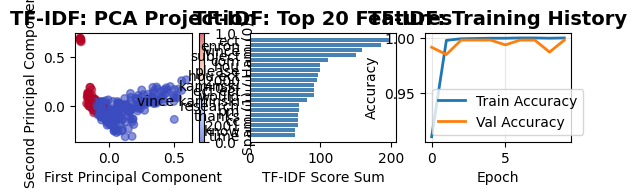

In [41]:
print("\n1. Creating TF-IDF visualization...")

# Train final TF-IDF model with best config
vectorizer = TfidfVectorizer(**best_tfidf_config)
X_train_tfidf = vectorizer.fit_transform(X_train).toarray()
X_test_tfidf = vectorizer.transform(X_test).toarray()

# Use PCA to reduce to 2D (TF-IDF is high-dimensional)
pca_tfidf = PCA(n_components=2)
X_tfidf_2d = pca_tfidf.fit_transform(X_test_tfidf[:500])  # Use first 500 samples

# Plot 1: TF-IDF PCA
ax1 = plt.subplot(3, 3, 1)
scatter1 = ax1.scatter(X_tfidf_2d[:, 0], X_tfidf_2d[:, 1],
                       c=y_test[:500], cmap='coolwarm', alpha=0.6, s=30)
ax1.set_title('TF-IDF: PCA Projection', fontsize=14, fontweight='bold')
ax1.set_xlabel('First Principal Component')
ax1.set_ylabel('Second Principal Component')
plt.colorbar(scatter1, ax=ax1, label='Spam (1) / Ham (0)')

# Plot 2: TF-IDF Feature Importance (Top 20 words)
ax2 = plt.subplot(3, 3, 2)
feature_names = vectorizer.get_feature_names_out()
tfidf_sum = X_train_tfidf.sum(axis=0)
top_20_idx = tfidf_sum.argsort()[-20:][::-1]
top_20_words = [feature_names[i] for i in top_20_idx]
top_20_scores = [tfidf_sum[i] for i in top_20_idx]

ax2.barh(range(20), top_20_scores, color='steelblue')
ax2.set_yticks(range(20))
ax2.set_yticklabels(top_20_words)
ax2.set_xlabel('TF-IDF Score Sum')
ax2.set_title('TF-IDF: Top 20 Features', fontsize=14, fontweight='bold')
ax2.invert_yaxis()

# Plot 3: TF-IDF Training History
ax3 = plt.subplot(3, 3, 3)
# Retrain to get history
model_tfidf = Sequential([
    InputLayer(input_shape=(X_train_tfidf.shape[1],)),
    Dense(256, activation="relu"),
    Dropout(0.3),
    Dense(128, activation="relu"),
    Dropout(0.3),
    Dense(64, activation="relu"),
    Dense(1, activation="sigmoid")
])
model_tfidf.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
history_tfidf = model_tfidf.fit(X_train_tfidf, y_train, validation_split=0.1,
                                 epochs=10, batch_size=32, verbose=0)

ax3.plot(history_tfidf.history['accuracy'], label='Train Accuracy', linewidth=2)
ax3.plot(history_tfidf.history['val_accuracy'], label='Val Accuracy', linewidth=2)
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Accuracy')
ax3.set_title('TF-IDF: Training History', fontsize=14, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

2. Creating Skip-gram visualization...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


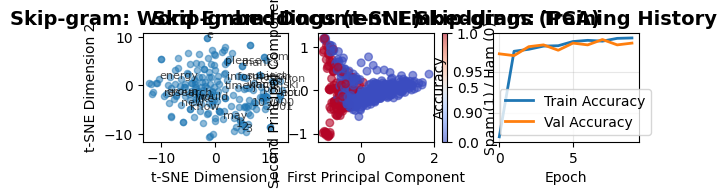

In [42]:
############### 2. SKIP-GRAM VISUALIZATION #######################
print("2. Creating Skip-gram visualization...")

# Train final Skip-gram model with best config
w2v_sg = Word2Vec(sentences=X_train_tokens, sg=1, **best_sg_config)
EMB_SIZE_SG = best_sg_config['vector_size']

# Get word vectors for visualization
words = list(w2v_sg.wv.index_to_key)[:200]  # Top 200 words
word_vectors_sg = np.array([w2v_sg.wv[word] for word in words])

# Use t-SNE to reduce to 2D
tsne_sg = TSNE(n_components=2, random_state=42, perplexity=30)
word_vectors_sg_2d = tsne_sg.fit_transform(word_vectors_sg)

# Plot 4: Skip-gram word embeddings
ax4 = plt.subplot(3, 3, 4)
ax4.scatter(word_vectors_sg_2d[:, 0], word_vectors_sg_2d[:, 1], alpha=0.5, s=20)
# Annotate some words
for i, word in enumerate(words[:30]):  # Show first 30 word labels
    ax4.annotate(word, (word_vectors_sg_2d[i, 0], word_vectors_sg_2d[i, 1]),
                fontsize=8, alpha=0.7)
ax4.set_title('Skip-gram: Word Embeddings (t-SNE)', fontsize=14, fontweight='bold')
ax4.set_xlabel('t-SNE Dimension 1')
ax4.set_ylabel('t-SNE Dimension 2')

# Plot 5: Skip-gram document embeddings
ax5 = plt.subplot(3, 3, 5)
X_test_sg = np.array([embed_sentence(tokens, w2v_sg, MAX_LEN, EMB_SIZE_SG)
                      for tokens in X_test_tokens[:500]])
# Average pooling to get document representation
X_test_sg_avg = X_test_sg.mean(axis=1)  # Shape: (500, EMB_SIZE)
pca_sg = PCA(n_components=2)
X_sg_2d = pca_sg.fit_transform(X_test_sg_avg)

scatter5 = ax5.scatter(X_sg_2d[:, 0], X_sg_2d[:, 1],
                       c=y_test[:500], cmap='coolwarm', alpha=0.6, s=30)
ax5.set_title('Skip-gram: Document Embeddings (PCA)', fontsize=14, fontweight='bold')
ax5.set_xlabel('First Principal Component')
ax5.set_ylabel('Second Principal Component')
plt.colorbar(scatter5, ax=ax5, label='Spam (1) / Ham (0)')

# Plot 6: Skip-gram Training History
ax6 = plt.subplot(3, 3, 6)
X_train_sg = np.array([embed_sentence(tokens, w2v_sg, MAX_LEN, EMB_SIZE_SG)
                       for tokens in X_train_tokens])
model_sg = Sequential([
    GRU(64, input_shape=(MAX_LEN, EMB_SIZE_SG)),
    Dense(32, activation="relu"),
    Dense(1, activation="sigmoid")
])
model_sg.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
history_sg = model_sg.fit(X_train_sg, y_train, validation_split=0.1,
                          epochs=10, batch_size=32, verbose=0)

ax6.plot(history_sg.history['accuracy'], label='Train Accuracy', linewidth=2)
ax6.plot(history_sg.history['val_accuracy'], label='Val Accuracy', linewidth=2)
ax6.set_xlabel('Epoch')
ax6.set_ylabel('Accuracy')
ax6.set_title('Skip-gram: Training History', fontsize=14, fontweight='bold')
ax6.legend()
ax6.grid(True, alpha=0.3)

3. Creating CBOW visualization...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



✓ Visualization saved as 'embedding_visualizations.png'


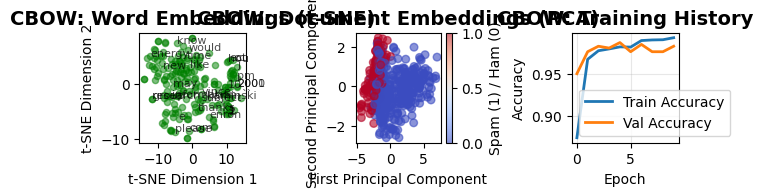

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [43]:
############### 3. CBOW VISUALIZATION #######################
print("3. Creating CBOW visualization...")

# Train final CBOW model with best config
w2v_cbow = Word2Vec(sentences=X_train_tokens, sg=0, **best_cbow_config)
EMB_SIZE_CBOW = best_cbow_config['vector_size']

# Get word vectors for visualization
word_vectors_cbow = np.array([w2v_cbow.wv[word] for word in words])

# Use t-SNE to reduce to 2D
tsne_cbow = TSNE(n_components=2, random_state=42, perplexity=30)
word_vectors_cbow_2d = tsne_cbow.fit_transform(word_vectors_cbow)

# Plot 7: CBOW word embeddings
ax7 = plt.subplot(3, 3, 7)
ax7.scatter(word_vectors_cbow_2d[:, 0], word_vectors_cbow_2d[:, 1], alpha=0.5, s=20, color='green')
# Annotate some words
for i, word in enumerate(words[:30]):
    ax7.annotate(word, (word_vectors_cbow_2d[i, 0], word_vectors_cbow_2d[i, 1]),
                fontsize=8, alpha=0.7)
ax7.set_title('CBOW: Word Embeddings (t-SNE)', fontsize=14, fontweight='bold')
ax7.set_xlabel('t-SNE Dimension 1')
ax7.set_ylabel('t-SNE Dimension 2')

# Plot 8: CBOW document embeddings
ax8 = plt.subplot(3, 3, 8)
X_test_cbow = np.array([embed_sentence(tokens, w2v_cbow, MAX_LEN, EMB_SIZE_CBOW)
                        for tokens in X_test_tokens[:500]])
X_test_cbow_avg = X_test_cbow.mean(axis=1)
pca_cbow = PCA(n_components=2)
X_cbow_2d = pca_cbow.fit_transform(X_test_cbow_avg)

scatter8 = ax8.scatter(X_cbow_2d[:, 0], X_cbow_2d[:, 1],
                       c=y_test[:500], cmap='coolwarm', alpha=0.6, s=30)
ax8.set_title('CBOW: Document Embeddings (PCA)', fontsize=14, fontweight='bold')
ax8.set_xlabel('First Principal Component')
ax8.set_ylabel('Second Principal Component')
plt.colorbar(scatter8, ax=ax8, label='Spam (1) / Ham (0)')

# Plot 9: CBOW Training History
ax9 = plt.subplot(3, 3, 9)
X_train_cbow = np.array([embed_sentence(tokens, w2v_cbow, MAX_LEN, EMB_SIZE_CBOW)
                         for tokens in X_train_tokens])
model_cbow = Sequential([
    GRU(64, input_shape=(MAX_LEN, EMB_SIZE_CBOW)),
    Dense(32, activation="relu"),
    Dense(1, activation="sigmoid")
])
model_cbow.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
history_cbow = model_cbow.fit(X_train_cbow, y_train, validation_split=0.1,
                              epochs=10, batch_size=32, verbose=0)

ax9.plot(history_cbow.history['accuracy'], label='Train Accuracy', linewidth=2)
ax9.plot(history_cbow.history['val_accuracy'], label='Val Accuracy', linewidth=2)
ax9.set_xlabel('Epoch')
ax9.set_ylabel('Accuracy')
ax9.set_title('CBOW: Training History', fontsize=14, fontweight='bold')
ax9.legend()
ax9.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('embedding_visualizations.png', dpi=300, bbox_inches='tight')
print("\n✓ Visualization saved as 'embedding_visualizations.png'")
plt.show()

# Download the visualization
files.download('embedding_visualizations.png')



4. Creating comparison visualization...
✓ Comparison saved as 'model_comparison.png'


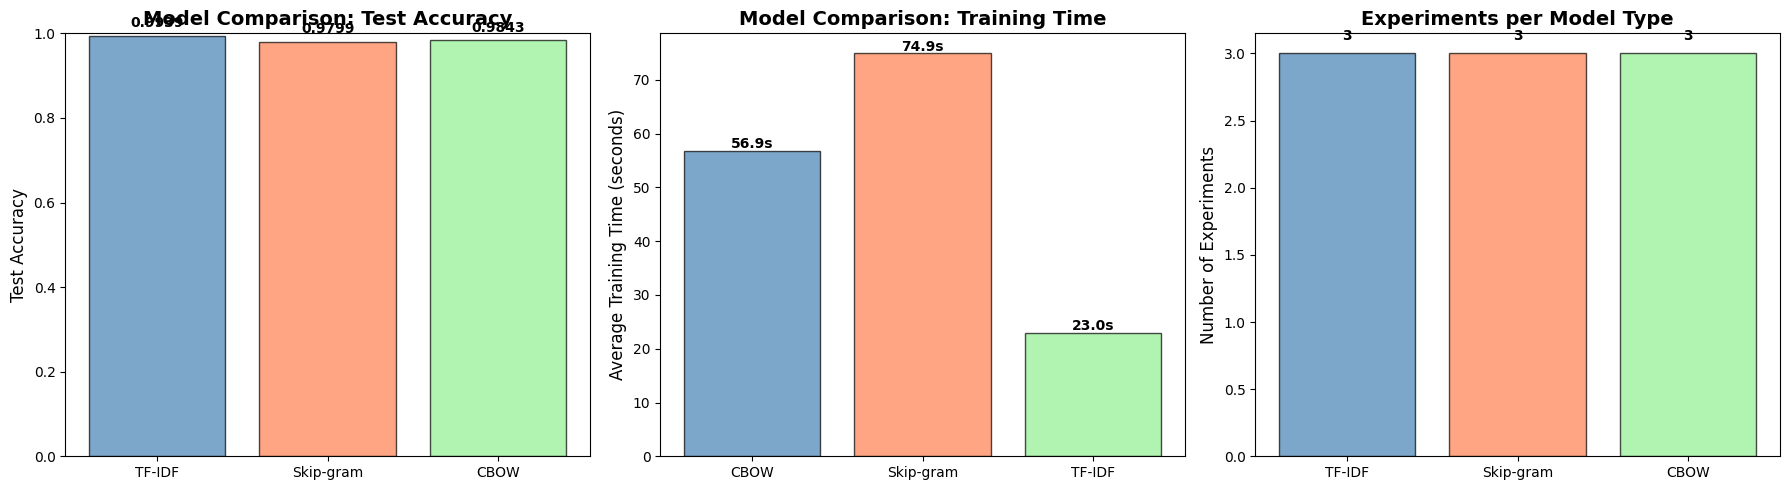

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


ALL VISUALIZATIONS COMPLETE!


In [44]:
############### ADDITIONAL: COMPARISON VISUALIZATION #######################
print("\n4. Creating comparison visualization...")

fig2, axes = plt.subplots(1, 3, figsize=(18, 5))

# Accuracy comparison
models = ['TF-IDF', 'Skip-gram', 'CBOW']
accuracies = [best_tfidf_acc, best_sg_acc, best_cbow_acc]
colors = ['steelblue', 'coral', 'lightgreen']

axes[0].bar(models, accuracies, color=colors, alpha=0.7, edgecolor='black')
axes[0].set_ylabel('Test Accuracy', fontsize=12)
axes[0].set_title('Model Comparison: Test Accuracy', fontsize=14, fontweight='bold')
axes[0].set_ylim([0, 1])
for i, v in enumerate(accuracies):
    axes[0].text(i, v + 0.02, f'{v:.4f}', ha='center', fontweight='bold')

# Training time comparison (from experiment log)
df_log = pd.DataFrame(experiment_log)
avg_times = df_log.groupby('model_type')['training_time_seconds'].mean()
axes[1].bar(avg_times.index, avg_times.values, color=colors, alpha=0.7, edgecolor='black')
axes[1].set_ylabel('Average Training Time (seconds)', fontsize=12)
axes[1].set_title('Model Comparison: Training Time', fontsize=14, fontweight='bold')
for i, (model, time) in enumerate(avg_times.items()):
    axes[1].text(i, time + 0.5, f'{time:.1f}s', ha='center', fontweight='bold')

# Experiment count
exp_counts = df_log['model_type'].value_counts()
axes[2].bar(exp_counts.index, exp_counts.values, color=colors, alpha=0.7, edgecolor='black')
axes[2].set_ylabel('Number of Experiments', fontsize=12)
axes[2].set_title('Experiments per Model Type', fontsize=14, fontweight='bold')
for i, (model, count) in enumerate(exp_counts.items()):
    axes[2].text(i, count + 0.1, f'{count}', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
print("✓ Comparison saved as 'model_comparison.png'")
plt.show()

files.download('model_comparison.png')

print("\n" + "="*60)
print("ALL VISUALIZATIONS COMPLETE!")
print("="*60)